# Assessing fire danger in a changing climate
## A 30-year fire weather index (FWI) exceedance probability analysis

### Definitions

Before diving into the analysis, let's define a couple of terms that are crucial to this study:
<div style="border:2px solid #009BFF; background-color: #E0F7FA; padding: 10px; border-radius: 10px;">
    <p><b style="color: #01579B;">Fire Weather Index (FWI):</b> The FWI is a component of the Canadian Forest Fire Weather Index System, serving as a numerical measure of fire intensity. It is derived from weather observations including temperature, humidity, wind speed, and precipitation. The FWI is instrumental in estimating the potential land flammability and severity of wildfires, thereby helping in fire management and mitigation efforts.</p>
    <p><b style="color: #01579B;">Probability of Exceedance:</b> This statistical measure indicates the likelihood that a certain variable, in our case the FWI, will surpass a predefined threshold. It is expressed as a probability, ranging from 0 to 1, where a higher value signifies a greater chance of exceeding the specified FWI threshold. Understanding the probability of exceedance is essential for assessing fire risk under various climate scenarios and making informed decisions for fire prevention and safety planning.</p>
</div>

In [4]:
### Import external libraries 
import metview as mv
import numpy as np 
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import SplineTransformer, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

Could not find manifest file for plugin int.ecmwf.atlas-orca
Could not find manifest file for plugin int.ecmwf.atlas-orca


### Data context

Our analysis is initially focused on fire weather conditions across several key locations in Finland: Jokioinen, Sodankylä, Vantaa, and Jyväskylä. These locations have been chosen due to their distinct climatic conditions, providing a diverse view of fire weather potential across the country.
The data extraction process is designed with flexibility in mind. Given latitude and longitude coordinates, the analysis can be extended to any location of interest within or beyond Finland. 

In [5]:
stations = ['Vanta', 'Jokioinen', 'Juvaskyla', 'Sodankyla']
station_index = 3 # Assuming you're interested in Sodankyla. Remember that in Python, the count starts from 0

var = "fwi"
station = stations[station_index] 

### Data analysis

The calculate_fwi_exceed_proba function is an important component of the fire risk assessment toolkit, designed to predict the probability that the FWI will exceed a specified threshold. It helps in understanding the potential for fire weather conditions under different climate scenarios. 
The function integrates meteorological data, including temperature and precipitation changes (dt and dp respectively) w.r.t to the baseline scenario, to assess how these changes might affect the FWI at a given location (station). It then calculates the probability that the FWI exceeds a predefined threshold, offering insights into potential fire weather conditions.

In [6]:
def calculate_fwi_exceed_proba(dt, dp, var, station, threshold):
    # Construct the filename and read the grib file
    path = '/home/masg/to_share/climax_fire/data/fwi_finland' 
    filename = f'point_{station}_{dt}_{dp}_1981_2010_{var}.grib'
    fwi = mv.read(f'{path}/{filename}')
    v_fwi = fwi.values()

    # Generate the date range and convert data to a timeserie
    dates = pd.date_range(start='1981-01-01', periods=len(v_fwi), freq='D')
    data = pd.Series(v_fwi.flatten(), index=dates)

    # Calculate yearly maximum FWI
    fwi_max = data.resample('Y').max()

    # Prepare the DataFrame for analysis
    df = fwi_max.to_frame(name="FWI")
    df['Rank'] = df.rank(method='min', ascending=False)
    df['PE'] = (df['Rank'] / (len(df) + 1)) * 100  # Applying Weibull formula

    # Sort the DataFrame based on FWI values
    df_sorted = df.sort_values(by='FWI', ascending=False)

    # Prepare data for modeling
    X = df_sorted['FWI'].values.reshape(-1, 1)
    y = df_sorted['PE'].values

    # Fit a B-spline model
    model = make_pipeline(SplineTransformer(n_knots=5, degree=3), Ridge(alpha=1e-3))
    model.fit(X, y)

    # Predict the probability of exceedance for the given threshold
    y_pred = model.predict(np.array([threshold]).reshape(-1, 1))
    predicted_pe = y_pred[0]

    ### Print key information 
    print_key_info = False
    if print_key_info: 
        # Dynamic explanation for temperature perturbation
        temperature_change = "an increase" if dt > 0 else "a decrease"
        temperature_magnitude = abs(dt)
        # Dynamic explanation for precipitation factor
        precipitation_change = "an increase" if dp > 1 else "a decrease"
        precipitation_magnitude = ((abs(float(dp) - 1) * 100) if dp != 1 else 0)
        print(f"For a climate scenario defined by {temperature_change} in temperature by {temperature_magnitude:.1f}°C "
          f"and {precipitation_change} in precipitation by {precipitation_magnitude:.0f}% with respect to the baseline scenario, "
          f"the predicted probability of exceeding a FWI threshold of {threshold}, is {predicted_pe:.3f}%.")

    # Return the predicted probability of exceedance for the threshold
    return predicted_pe

In [7]:
# Let's assume that we're interested in a FWI threshold of 30; High fire danger
threshold = 30

# Initialise an empty list to store results
results = []

print("The exceedance probability computation function is now running.")
print(f"Please wait approximately 2 minutes...")
# Use numpy to generate perturbations of temperature (t) and precipitation (p)
for t in np.arange(0.0, 7.0, 1.0):
    for p in np.arange(0.6, 1.7, 0.2):
        dt, dp = round(t, 1), round(p, 1)
        
        # Call the predefined function
        pe = calculate_fwi_exceed_proba(dt, dp, var, station, threshold)
        
        # Append the results as a dictionary to facilitate DataFrame creation
        results.append({'dt': dt, 'dp': dp, 'PE': pe})

# Convert the list of dictionaries to a DataFrame for easy manipulation and analysis
df_res = pd.DataFrame(results)

The exceedance probability computation function is now running.
Please wait approximately 1 minute...


In [8]:
# Display the first 10 rows of the DataFrame, which includes columns for Temperature, Precipitation, 
# and the calculated Probability of Exceeding the FWI Threshold. This provides a quick snapshot of 
# how changes in temperature and precipitation influence the probability.
df_res.head(10)

,dt,dp,PE
0,0.0,0.6,44.453015
1,0.0,0.8,31.102253
2,0.0,1.0,19.844002
3,0.0,1.2,12.828782
4,0.0,1.4,8.617145
5,0.0,1.6,6.910146
6,1.0,0.6,50.750675
7,1.0,0.8,36.724551
8,1.0,1.0,24.988236
9,1.0,1.2,16.956121


### Data visualisation

#### Impact Response Surface

In [9]:
### Construct the matrix for IRS using a polynomial model

def construct_rs(df, qoi):
    # Extract the quantity of interest and reshape for regression
    Y_train = np.array(df[qoi]).reshape(-1, 1)
    # Convert 'dt' and 'dp' columns to float and stack them for regression features
    X_train = np.column_stack([df['dt'].astype(float), df['dp'].astype(float)])
    
    # Set up sampling grid
    p = 500
    x1 = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), p)
    x2 = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), p)
    xsample = np.transpose([np.tile(x1, len(x2)), np.repeat(x2, len(x1))])
    
    # Polynomial regression
    poly_features = PolynomialFeatures(degree=4)
    X_train_poly = poly_features.fit_transform(X_train)
    poly_model = LinearRegression().fit(X_train_poly, Y_train)
    
    # Predict on the generated grid
    mm = poly_model.predict(poly_features.transform(xsample)).reshape(p, p)
    
    return mm, x1, x2

Call the construct_rs function with the DataFrame df_res and the 'PE' column as the quantity of interest.
The function performs polynomial regression to model the relationship between 'dt' and 'dp' variables and the 'PE' response. It returns a matrix 'mm' containing predicted values across a grid defined by 'x1' and 'x2', where 'x1' are linearly spaced values between the minimum and maximum of 'dt' and 'x2' are similarly spaced for 'dp'.
This matrix 'mm' is used to analyze how changes in 'dt' and 'dp' might influence 'PE'.

In [10]:
mm, x1, x2 = construct_rs(df_res, 'PE')

#### CMIP6 climate projections

The script below processes climate projection data for temperature and precipitation from 36 different climate models from CMIP6 ensemble, covering all months of the year. The data, sourced from CSV files, includes temperature (d_tas) and precipitation (d_pr) projections under various climate scenarios. The script dynamically constructs file paths based on parameters such as region, variable type, term, and scenario.

In [11]:
region = 'NEU' # Finland: Northern Europe
path_cc = '/home/masg/to_share/climax_fire/data/cmip6_proj'

def get_file_path(region, variable, term, scenario):
    """Constructs the file path for a given variable and term within a scenario."""
    return f"{path_cc}/{region}/{variable}/{term}/{scenario}.csv"

def compute_data(file_path, data_column):
    """Reads specific data from a CSV file, reshapes it, and computes the mean."""
    data = pd.read_csv(file_path)
    data_series = data[data_column]  # Read the specific column from the CSV
    reshaped_data = data_series.values.reshape(36, 12).T
    data_df = pd.DataFrame(reshaped_data)
    return data_df.mean(axis=0)

def derive_cloud_cc_proj(region, term, scenario='ssp245'):
    """Processes climate data for temperature and precipitation, returning their means."""
    var_data_columns = {'tas': 'd_tas', 'pr': 'd_pr'}
    results = []

    for variable, data_column in var_data_columns.items():
        file_path = get_file_path(region, variable, term, scenario)
        mean_values = compute_data(file_path, data_column)
        results.append(mean_values)
    
    t_mean, p_mean = results
    p_mean += 1  
    return t_mean, p_mean

t_mean_mt, p_mean_mt = derive_cloud_cc_proj(region, 'mid_term')
t_mean_lt, p_mean_lt = derive_cloud_cc_proj(region, 'long_term')

### Optionally, print the results:
# print("Mid Term Temperature Mean: \n", t_mean_mt)
# print("Mid Term Precipitation Mean Incremented: \n", p_mean_mt)
# print("Long Term Temperature Mean: \n", t_mean_lt)
# print("Long Term Precipitation Mean Incremented: \n", p_mean_lt)

In [12]:
def plot_exceed_proba(mm, x1, x2, t_mean, p_mean, term, station_index, threshold):
    plt.cla()
    levels = list(range(10, 100, 10))
    vmin, vmax, vlut = 0, 100, 10

    # Define the period label based on the term argument
    period_label, marker_style, cmap_style = ('2036-2065', 'go', 'Greens_d') if term == 'mid_term' else ('2070-2099', 'm^', 'Purples_d')

    # Contour and heat map plotting
    contours = plt.contour(x1, x2, mm, levels, colors='black')
    plt.clabel(contours, inline=True, fontsize=11)
    cmap = cm.get_cmap("YlOrBr", lut=vlut)
    plt.pcolormesh(x1, x2, mm, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
    cbar = plt.colorbar(boundaries=list(range(vmin, vmax + 10, 10)))
    cbar.ax.tick_params(labelsize=7)

    # Assign station names based on index
    exact_names = ['Vantaa', 'Jokioinen', 'Jyväskylä', 'Sodankylä']
    exact_name = exact_names[station_index]

    plt.title(f"Probability of Exceeding an FWI threshold of {threshold} \n at {exact_name}", fontsize=12)
    plt.xlabel('Temperature change [°C]')
    plt.ylabel('Precipitation change [%]')

    # KDE plot for projections
    sns.kdeplot(x=t_mean, y=p_mean, cmap=cmap_style, shade=True, levels=50, thresh=0.0001, vmax=np.mean(p_mean))
    plt.plot(t_mean, p_mean, marker_style, markersize=4, label=f'{period_label} \n CMIP6 projections')
    plt.plot(np.mean(t_mean), np.mean(p_mean), marker='o', color="tomato", markersize=10)

    # Adjust y-ticks
    locs, labels = plt.yticks()
    labels = [int(round((i - 1) * 100, 0)) for i in locs]
    plt.yticks(locs, labels, rotation='vertical')

    plt.plot(0, 1, color='black', marker='o', markersize=10)
    plt.ylim(0.55, 1.65)
    plt.xlim(-0.2, 6.2)
    plt.legend()
    plt.show()

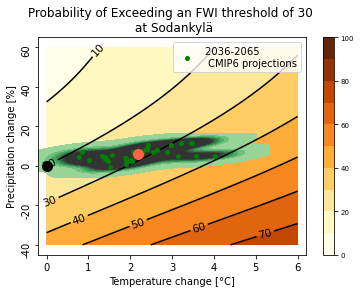

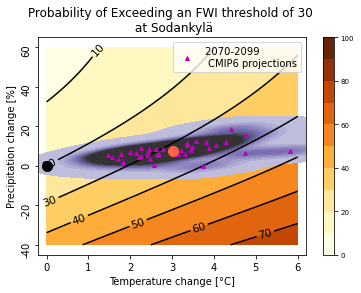

In [13]:
### Example usage with the specific FWI threshold in the title
## mid term
plot_exceed_proba(mm, x1, x2, t_mean_mt, p_mean_mt, 'mid_term', station_index=station_index, threshold=threshold)
## long term
plot_exceed_proba(mm, x1, x2, t_mean_lt, p_mean_lt, 'long_term', station_index=station_index, threshold=threshold)

#### Interpretation
The IRS (Impact Response Surface) output represents how changes in temperature and precipitation affect the probability of exceeding a specific FWI threshold, in this example 30. The contour and pcolormesh plots illustrate the interaction between these two climatic factors. In these plots, temperature change is represented on the x-axis and precipitation change on the y-axis, with the resulting probabilities depicted through variations in color. The darker or more intense the color, the higher the probability of exceeding the FWI threshold. Contour lines are superimposed to delineate areas of equal probability. Additionally, the CMIP6 projections for both mid-term and long-term scenarios are superimposed on the IRS to assess the likelihood of exceeding critical thresholds in fire weather conditions as climate variables shift. 